In [1]:
import os
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
from tqdm.notebook import tqdm
from glob import glob
import fastai
import re
import csv

2022-07-06 00:42:18.745605: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print(torch.__version__)
print(transformers.__version__)
print(fastai.__version__)

1.7.1
4.21.0.dev0
2.2.5


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PRETRAINED_MODEL = 'skt/kogpt2-base-v2'
BATCH_SIZE = 8
SEQ_LENGTH = 256
MAX_LENGTH = 512
DATASET_PATH = './data/jjaltoon_scripts_130/'

In [4]:
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    PRETRAINED_MODEL,
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>',
    bos_token='<s>',
    eos_token='</s>'
)
model = AutoModelWithLMHead.from_pretrained(PRETRAINED_MODEL)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:969: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [5]:
tokenizer.tokenize('GPT-2 토크나이저 테스트. 안녕하세요.')

['▁G',
 'P',
 'T',
 '-2',
 '▁토크',
 '나이',
 '저',
 '▁테',
 '스트',
 '.',
 '▁안녕',
 '하',
 '세',
 '요.']

In [6]:
text = '오늘의 메뉴는'
input_ids = tokenizer.encode(text)
gen_ids = model.generate(
    torch.tensor([input_ids]),
    max_length=MAX_LENGTH,
    repetition_penalty=2.0,
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    use_cache=True
)
generated = tokenizer.decode(gen_ids[0,:].tolist())
generated

'오늘의 메뉴는 ‘치킨’. 치즈에 햄을 넣어 만든 소스다.\n이렇게 해서 나온 것이 바로 닭가슴살이다.\n닭 가슴살은 육질이 부드럽고 담백해 남녀노소 누구나 좋아하는 음식 중 하나다.\n특히, 이번에 선보인 신메일은 국내산 돼지고기를 사용해 더욱 고소하고 부드러운 맛을 느낄 수 있다.\n또한 양파, 마늘 등 야채와 함께 곁들여 먹으면 더 맛있게 먹을 수도 있다.</d> 지난달 30일 서울 강남구 삼성동 코엑스에서 열린 \'2018 대한민국 디자인대상\' 시상식에서 한국디자인진흥원이 주최하는 이번 공모전은 총 330여점의 작품이 접수됐다.\n심사위원단은 "한국 디자인의 우수성을 널리 알리고 디자인을 통한 국가 경쟁력 제고에 기여하고자 하는 취지에서 기획됐다"고 선정 이유를 밝혔다.\n수상작은 ▲김영란법 시행으로 인한 소비심리 위축과 저성장 기조 속에서 소비자의 생활 패턴 변화를 반영한 제품(박성수)▲소비자 중심의 새로운 라이프스타일을 제안할 상품(이종훈), 소비자 중심형 제품을 개발·생산·유통·판매하기 위한 전략 및 아이디어 등이 담긴 작품(\'장윤주)\' 등이다.\n심사는 심사위원회 심사를 거쳐 수상작을 최종 확정했다.\n시상식은 오는 11월 2일 오후 2시부터 5시까지 열린다.\n올해로 3회째를 맞는 2018대한민국 디자인이벤트는 산업통상자원부가 주관하고, 한국산업디자이너협회가 주관하는 행사다. 가격은 1만원부터 10만원(세금 포함)이다.\n공모전 참가 신청은 다음 달 1일부터 31일까지이며, 자세한 내용은 홈페이지(www.kidsi.kr)에서 확인할 수가 있으며, 기타 문의사항도 가능하다..\n최우수상은 △신제품개발팀의 `아임유`가 수상했다.\n아이디어는 창의성과 실용성이 돋보이며 제품의 완성도를 높였다는 평가를 받았다.\n장려상에는 ▷정재희 팀장의 아이디어가 돋보이는 제품이 뽑혔다.\n△강민경 씨와 김지현 씨의 공동작업물품이 출품돼 눈길을 끌었다.\n선발된 작품은 내년 1월 중순께 출시될 예정이다.\n산업통상자원부 관계자는 "이번 행사는 산업디자인의 중요

In [7]:
def get_file_list(data_path, pattern):
    filelist = []

    for dir, _, _ in os.walk(data_path):
        filelist.extend(glob(os.path.join(dir, pattern)))
    
    return filelist

In [8]:
texts = []

file_list = get_file_list(DATASET_PATH, '*.csv')
for file_path in tqdm(file_list, desc='input data files'):
    with open(file_path, mode='r', encoding='utf-8') as file:
        #file_content = file.read()
        reader = csv.DictReader(file)
        speeches = []
        for row in reader:
            if row['type'] == 'speech':
                speeches.append(row['speech'])
    texts.append('\n'.join(speeches))

data = ' '.join(texts)
len(data)

input data files:   0%|          | 0/129 [00:00<?, ?it/s]

292139

In [9]:
# Normalization
data = re.sub('[●○]', '', data)
data = re.sub('!+', '!', data)
data = re.sub('\?+', '?', data)
data = re.sub('(\?!|!\?)+', '?!', data)
data = re.sub('\.\.\.\.+', '...', data)
len(data)

284068

In [10]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    
    def encodes(self, x):
        tokens = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(tokens))
    
    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [11]:
train_data = data[:int(len(data) * 0.9)]
test_data = data[int(len(data) * 0.9):]
splits = [[0], [1]]

In [12]:
tls = TfmdLists([train_data, test_data], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=BATCH_SIZE, seq_len=SEQ_LENGTH)
dls.show_batch(max_n=2)

/usr/local/lib/python3.8/dist-packages/fastai/torch_core.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/usr/local/lib/python3.8/dist-packages/fastai/torch_core.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/usr/local/lib/python3.8/dist-packages/fastai/torch_core.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/usr/local/lib/python3.8/dist-packages/fastai/torch_core.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,text_
0,"내이름은 사탄! 크리스마스도 다가오고 산타클로스 회사에서 아르바이트를 시작했다!\n자 한명씩 호명할게요...김 산타씨?\n네\n마이클 드 산타씨?\n나마씨발. 엿이나 먹어!)\n...사탄씨?\n네!\n예. 그. 예. 연재를 안해줘서요.\n그럼 이제 이번 아르바이트부터는 계속 꾸준히 일 하실 생각이신가요?\n(표정하나 바뀌지않고 ) 아뇨.\n어... 그래도 사탄씨 같은사람이 일 안하기는 좀 아까운데\n안해요.\n어...그래. 뭐 어쩔수 없지. 일단 일을 시작해볼까?\n자네는 오늘 처음왔으니까... 어디보자..(종이를보며) 어. 서울 쪽만 좀 부탁해~?\n반장님은 어디 가시는데요?\n나는 저기 그~~~ 저기 더 넓은 곳 돌아야 돼\n안성\n서울이 더 넓잖아요\n야!\n휴...됐다. 오랜만에 일하는건데 좀 많이하지 뭐. 하지만 아무리그래도 나는 사탄!\n흐흐흐 문도 제대로 안잠궈놓고 세상모르고 자고있군!\n(여자목소리로) 어머깜짝이야!\n어...뭐,뭐야! 당신 누구야!\n나는","이름은 사탄! 크리스마스도 다가오고 산타클로스 회사에서 아르바이트를 시작했다!\n자 한명씩 호명할게요...김 산타씨?\n네\n마이클 드 산타씨?\n나마씨발. 엿이나 먹어!)\n...사탄씨?\n네!\n예. 그. 예. 연재를 안해줘서요.\n그럼 이제 이번 아르바이트부터는 계속 꾸준히 일 하실 생각이신가요?\n(표정하나 바뀌지않고 ) 아뇨.\n어... 그래도 사탄씨 같은사람이 일 안하기는 좀 아까운데\n안해요.\n어...그래. 뭐 어쩔수 없지. 일단 일을 시작해볼까?\n자네는 오늘 처음왔으니까... 어디보자..(종이를보며) 어. 서울 쪽만 좀 부탁해~?\n반장님은 어디 가시는데요?\n나는 저기 그~~~ 저기 더 넓은 곳 돌아야 돼\n안성\n서울이 더 넓잖아요\n야!\n휴...됐다. 오랜만에 일하는건데 좀 많이하지 뭐. 하지만 아무리그래도 나는 사탄!\n흐흐흐 문도 제대로 안잠궈놓고 세상모르고 자고있군!\n(여자목소리로) 어머깜짝이야!\n어...뭐,뭐야! 당신 누구야!\n나는 사"
1,"으며) 뭔데, 함 봐바 새<unk>~\n아앗..!\n(민중의 폰을 보며) 응? 뭐야 이거 엌ᄏᄏᄏᄏᄏ (다른 아이들에게 소리치듯) 야! 이 새끼 쇼미 하이라이트 본다!\n(인상 찌푸리며) 에? 혼또?\n(옆의 다른 여자 애에게 묻듯이) 쇼미? 그게 뭐야...?\n그거 막 인싸들이나 보는 거 아님?\n(폰을 뺏으려 들며) 도... 돌려줘...!\nᄏᄏ 김민중 이<unk> 그냥 일진인줄만 알았는데 힙찔이 설정까지 있었냐고~\n노래방 가면 막 랩 같은 거 부르는 거 아냐? 랄까 극혐이라구 어이!\n(얼굴이 빨개져서 부들대며) 으으....\n(핸드폰을 몇번 만지작거리면서) 어? 야 잠깐 이 새끼 인스타도 하는데?\n아... 안돼...! 보지마!\n(동민이 들고 있는 휴대폰을 보며) 뭐야 이거...? 본인 방금 손흥민 되는 상상함? (휴대폰 화면이 보이면서 글 읽는 톤으로) 나 괴롭히던 십덕들 (박형우, 김동",") 뭔데, 함 봐바 새<unk>~\n아앗..!\n(민중의 폰을 보며) 응? 뭐야 이거 엌ᄏᄏᄏᄏᄏ (다른 아이들에게 소리치듯) 야! 이 새끼 쇼미 하이라이트 본다!\n(인상 찌푸리며) 에? 혼또?\n(옆의 다른 여자 애에게 묻듯이) 쇼미? 그게 뭐야...?\n그거 막 인싸들이나 보는 거 아님?\n(폰을 뺏으려 들며) 도... 돌려줘...!\nᄏᄏ 김민중 이<unk> 그냥 일진인줄만 알았는데 힙찔이 설정까지 있었냐고~\n노래방 가면 막 랩 같은 거 부르는 거 아냐? 랄까 극혐이라구 어이!\n(얼굴이 빨개져서 부들대며) 으으....\n(핸드폰을 몇번 만지작거리면서) 어? 야 잠깐 이 새끼 인스타도 하는데?\n아... 안돼...! 보지마!\n(동민이 들고 있는 휴대폰을 보며) 뭐야 이거...? 본인 방금 손흥민 되는 상상함? (휴대폰 화면이 보이면서 글 읽는 톤으로) 나 괴롭히던 십덕들 (박형우, 김동민)"


In [13]:
class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)

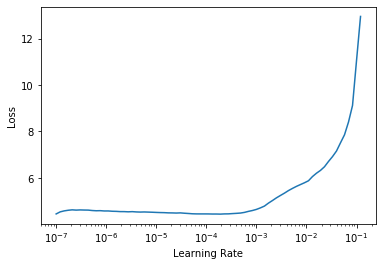

In [14]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn.lr_find()

In [ ]:
#learn.unfreeze()
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,perplexity,time
0,4.550223,4.538737,93.572571,00:18
1,4.612425,5.435915,229.502853,00:19
2,4.393174,5.716810,303.933746,00:19
3,3.807018,5.995734,401.711517,00:19
4,3.131456,6.213803,499.597748,00:19
5,2.416836,6.401273,602.611511,00:19
6,1.736235,6.516711,676.350037,00:19
7,1.155201,6.574477,716.570923,00:19


In [ ]:
def generate_sequence(prompt):
    prompt_ids = tokenizer.encode(prompt)
    inp = tensor(prompt_ids)[None].cuda()
    preds = learn.model.generate(
        inp,
        max_length=MAX_LENGTH,
        pad_token_id=tokenizer.pad_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        use_cache=True
    )
    return tokenizer.decode(preds[0].cpu().numpy())

In [ ]:
generate_sequence('내 이름은')

In [ ]:
!grep -r '반가워하며' ./data/